In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import yaml
import math
from tqdm import tqdm, trange
import os

import matplotlib.pyplot as plt
import seaborn as sns   

import copy
from tqdm import tqdm

from sklearn.metrics import (
    f1_score, 
    balanced_accuracy_score, 
    confusion_matrix,
    ConfusionMatrixDisplay, 
    accuracy_score,
    classification_report
)
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter
from imblearn.over_sampling import SMOTE

import warnings
from cnn_utils import (
    PTB_Dataset,
    EarlyStopping,
    set_all_seeds,
    train_and_validate,
    test,
)

from torch import Tensor

pd.set_option('display.max_columns', None)

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 42

TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256

N_EPOCHS=200


In [3]:
#path= r'C:\Users\pauls\Desktop\Studium\Machine Learning for Health Care\Projekt 2\project2_TS_input'
path = "../../data"

In [4]:
# Load data
train_df = pd.read_csv(os.path.join(path, 'ptbdb_train.csv'), header=None)
test_df = pd.read_csv(os.path.join(path, 'ptbdb_test.csv'), header=None)

In [5]:
X_train_full = train_df.iloc[:, :-1].to_numpy()
y_train_full = train_df.iloc[:, -1].to_numpy()

X_test = test_df.iloc[:, :-1].to_numpy()
y_test = test_df.iloc[:, -1].to_numpy()

Split into train and validation sets:

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=SEED
)

Moreover, to deal with the large class imbalance, which we discovered in our EDA, we will use SMOTE oversampling to balance the classes in the training set and provide some data augmentation.

In [7]:
sm = SMOTE(random_state=SEED)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [8]:
train_loader = DataLoader(
        PTB_Dataset(X_train, y_train),
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True,
        pin_memory=True,
        num_workers=0,
    )
val_loader = DataLoader(
    PTB_Dataset(X_val, y_val),
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

test_loader = DataLoader(
    PTB_Dataset(X_test, y_test),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

# The CNN:

## CNN Class Definition: 

In [15]:
# We based our CNN on this: https://medium.com/@chen-yu/building-a-customized-residual-cnn-with-pytorch-471810e894ed

class CNN(nn.Module):
    def __init__(self, classes_num: int, in_channels: int):
        super().__init__()

        # Initial convolution layer
        # self.conv = nn.Conv1d(
        #     in_channels=in_channels, 
        #     out_channels=16, 
        #     #kernel_size=(3, 3), 
        #     kernel_size=3,
        #     padding='same', 
        #     bias=False
        # )
        # self.bn = nn.BatchNorm1d(16)
        # self.relu = nn.ReLU()
        self.conv1 = self._create_conv_block(in_channels, 32, 3, 1)
        self.conv2 = self._create_conv_block(32, 64, 3, 1)
        self.conv3 = self._create_conv_block(64, 128, 3, 1)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(output_size = 10)
        

        #Out features from the 4 blocks of residual layers: 128
        
        
        # Flattening and final linear layer
        self.flatten = nn.Flatten(1)
        #self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Sequential(
            nn.Linear(1280, 256),
            nn.Hardswish(),
            nn.Dropout(p=0.2),  
            nn.Linear(256, classes_num)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = x.unsqueeze(1) # Add channel dimension
        # now: [batch_size, in_channels, seq_len] i.e. [batch_size, 1, 187]
        
        
        
        # x = self.conv(x)
        # x = self.bn(x)
        # x = self.relu(x)

        # #print("Shape after convolution and activation:", x.shape)

        # x = self.flatten(x)
        # #print("Shape after flattening:", x.shape)
        # x = self.dropout(x)
        # x = self.linear(x)
        # #print("Shape after linear layer:", x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.adaptive_pool(x)
        
        x = self.flatten(x)
        x = self.fc(x)
        return x
    
    def _create_conv_block(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        return nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )


set_all_seeds(SEED)
model=CNN(classes_num=2, in_channels=1)

## Training the CNN:

In [16]:
model = model.to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", factor=0.5, patience=5, threshold=1e-06, verbose=1
)
early_stopping = EarlyStopping(start=20, patience=20, verbose=1, mode="max")
summary_writer = SummaryWriter(log_dir="logs/cnn")

In [17]:
model = train_and_validate(
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    criterion = criterion,
    train_loader = train_loader,
    val_loader = val_loader,
    best_model_path = "../weights/cnn_no_res_blocks.pth", #os.path.join(path, 'cnn_best_model.pth'),
    device = DEVICE,
    num_epochs = N_EPOCHS,
    ES = early_stopping,
    summary_writer = summary_writer
)

Training Transformer:  25%|██▌       | 50/200 [01:35<04:45,  1.91s/it, train_balanced_acc=1, train_loss=4.37e-6, val_balanced_acc=0.994, val_loss=0.000275]     

Early stopping at epoch 50. Best score was 0.9942 in epoch 30.


## Evaluating the CNN:

In [18]:
model_probs, y_preds, y_true, test_loss = test(
    model = model,
    criterion = criterion, 
    test_loader = test_loader, 
    device = DEVICE
)

Test loss: 0.0004, Test accuracy: 0.9966, Test balanced accuracy: 0.9946, Test F1 score: 0.9976


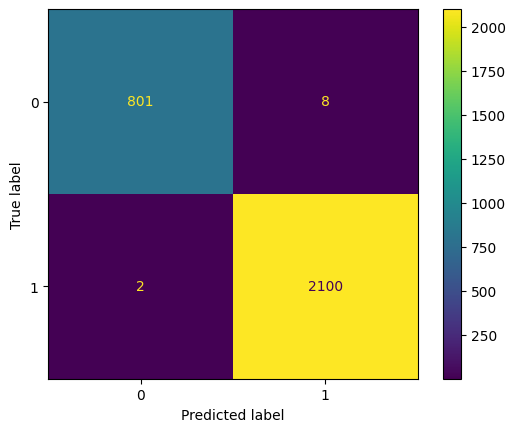

In [19]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [20]:
# calculate precision and recall:
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Test loss: {test_loss:.6f}")
print(f"Test accuracy: {accuracy_score(y_true, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(y_true, y_preds):.6f}")
print(f"Test f1 score: {f1_score(y_true, y_preds):.6f}")
print(f"Test precision: {precision:.6f}")
print(f"Test recall: {recall:.6f}")

Test loss: 0.000403
Test accuracy: 0.996565
Test balanced accuracy: 0.994580
Test f1 score: 0.997625
Test precision: 0.996205
Test recall: 0.999049


In [23]:
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       809
           1       1.00      1.00      1.00      2102

    accuracy                           1.00      2911
   macro avg       1.00      0.99      1.00      2911
weighted avg       1.00      1.00      1.00      2911



In [ ]:
path+'cnn_best_model.pth'

'../../datacnn_best_model.pth'